In [1]:
import pandas as pd
try:
  import pickle5 as pickle
except:
  !pip install pickle5
  import pickle5 as pickle
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding,  Concatenate, Lambda
from keras.models import Model
from sklearn.metrics import roc_auc_score,roc_curve, auc
from numpy import random
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import seaborn as sns

import sys
sys.path.insert(0,'/content/drive/MyDrive/ML_Data/')
import functions as f

     |████████████████████████████████| 133kB 8.2MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219248 sha256=2addc77d24138f15192b087dc21738facf66be8dfb2bea28f5034945ed75acff
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [2]:

def load_data(randomize=False):
    try:
        with open("/content/drive/MyDrive/ML_Data/hyppi-train.pkl", "rb") as fh:
          df_train = pickle.load(fh)
    except:
        df_train = pd.read_pickle("C:/Users/nik00/py/proj/hyppi-train.pkl")
    try:
        with open("/content/drive/MyDrive/ML_Data/hyppi-independent.pkl", "rb") as fh:
          df_test = pickle.load(fh)
    except:
        df_test = pd.read_pickle("C:/Users/nik00/py/proj/hyppi-independent.pkl")
    if randomize:
        return shuff_together(df_train,df_test)
    else:
        return df_train,df_test

df_train,df_test = load_data()
print('The data used will be:')
df_train[['Human','Yersinia']]

The data used will be:


,Human,Yersinia
0,"[M, K, D, K, Q, K, K, K, K, E, R, T, W, A, E, ...","[M, A, K, A, S, R, H, N, L, S, I, G, I, S, M, ..."
1,"[M, S, W, S, G, L, L, H, G, L, N, T, S, L, T, ...","[M, Q, H, V, T, G, S, K, R, R, L, I, G, W, V, ..."
2,"[M, S, L, F, D, L, F, R, G, F, F, G, F, P, G, ...","[M, A, E, L, P, A, K, R, R, F, T, R, I, D, R, ..."
3,"[M, A, V, A, P, R, L, F, G, G, L, C, F, R, F, ...","[M, R, I, F, A, I, S, C, S, S, Y, T, Y, C, Y, ..."
4,"[M, S, T, I, Q, S, E, T, D, C, Y, D, I, I, E, ...","[M, S, Y, A, F, P, G, T, F, P, G, R, R, M, R, ..."
...,...,...
6265,"[M, S, Y, F, G, E, H, F, W, G, E, K, N, H, G, ...","[M, I, T, T, D, G, N, S, A, V, A, S, V, A, Y, ..."
6266,"[M, T, V, G, K, S, S, K, M, L, Q, H, I, D, Y, ...","[M, S, Q, P, P, F, W, Q, Q, K, T, L, A, E, M, ..."
6267,"[M, N, N, L, S, F, S, E, L, C, C, L, F, C, C, ...","[M, S, E, D, R, H, Q, Q, R, Q, Q, R, L, K, E, ..."
6268,"[M, A, P, E, I, N, L, P, G, P, M, S, L, I, D, ...","[M, K, N, L, S, F, V, A, G, L, V, I, L, L, G, ..."


Median length of Human sequence is 479


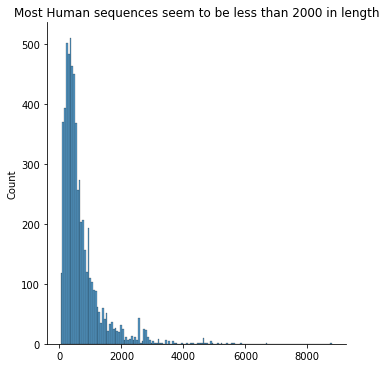

In [ ]:
lengths = sorted(len(s) for s in df_train['Human'])
print("Median length of Human sequence is",lengths[len(lengths)//2])
_  = sns.displot(lengths)
_=plt.title("Most Human sequences seem to be less than 2000 in length")

Median length of Yersinia sequence is 336


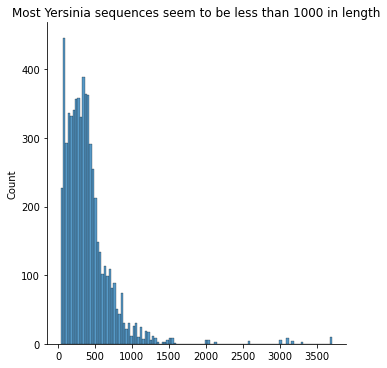

In [ ]:
lengths = sorted(len(s) for s in df_train['Yersinia'])
print("Median length of Yersinia sequence is",lengths[len(lengths)//2])
_  = sns.displot(lengths)
_=plt.title("Most Yersinia sequences seem to be less than 1000 in length")

MAX_VOCAB_SIZE is 1000
MAX_SEQUENCE_LENGTH is 1500
max sequences1_train length: 8797
min sequences1_train length: 41
median sequences1_train length: 479


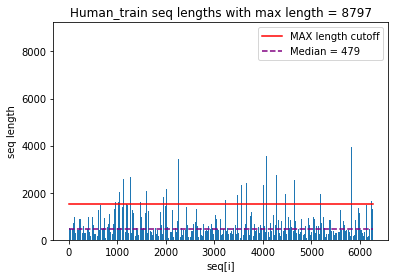

max word index sequences1_train: 20
max sequences2_train length: 3710
min sequences2_train length: 35
median sequences2_train length: 336


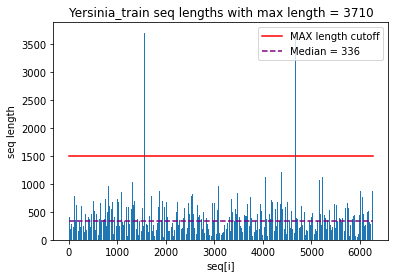

max word index sequences2_train: 20
Found 20 unique tokens in tokenizer1.
Found 20 unique tokens in tokenizer2.
pre padding
Shape of data1 tensor: (6270, 1500)
Shape of data2 tensor: (6270, 1500)
max test_sequences1 length: 5635
min test_sequences1 length: 39
median test_sequences1 length: 496


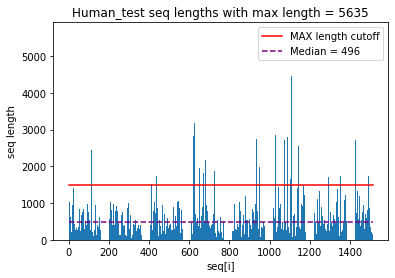

max test_sequences2 length: 3710
min test_sequences2 length: 35
median test_sequences2 length: 331


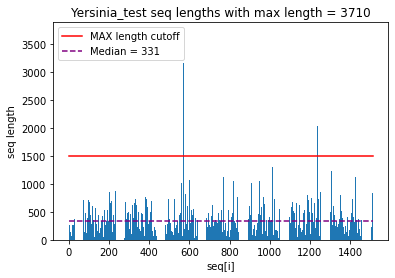

pre padding for test seq.
Shape of test_data1 tensor: (1514, 1500)
Shape of test_data2 tensor: (1514, 1500)
num_words is 21


In [6]:
data1_1D_doubleip,data2_1D_doubleip,data1_test_1D_doubleip,data2_test_1D_doubleip,num_words_1D,MAX_SEQUENCE_LENGTH_1D,MAX_VOCAB_SIZE_1D = f.get_seq_data_doubleip(1000,1500,df_train,df_test, pad='pre', show=True)

In [5]:
EMBEDDING_DIM_1D = 5
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 20
M_1D=10

inputA = Input(shape=(MAX_SEQUENCE_LENGTH_1D,),name="Human_1D_doubleip")
x1 = f.embedding_layer(num_words_1D,MAX_SEQUENCE_LENGTH_1D,EMBEDDING_DIM_1D)(inputA)
x1 = Bidirectional(LSTM(M_1D, return_sequences=True),name="Human_Bidirectional")(x1)
x1 = Dropout(0.2)(x1)
x1 = Dense(128, activation='relu')(x1)
#x1 = Dropout(0.2)(x1)
x1 = GlobalMaxPool1D()(x1)
x1 = Model(inputs=inputA, outputs=x1)

inputB = Input(shape=(MAX_SEQUENCE_LENGTH_1D,),name="Yersinia_1D_doubleip")
x2 = f.embedding_layer(num_words_1D,MAX_SEQUENCE_LENGTH_1D,EMBEDDING_DIM_1D)(inputB)
x2 = Bidirectional(LSTM(M_1D, return_sequences=True),name="Yersinia_Bidirectional")(x2)
x2 = Dropout(0.2)(x2)
x2 = Dense(128, activation='relu')(x2)
#x2 = Dropout(0.2)(x2)
x2 = GlobalMaxPool1D()(x2)
x2 = Model(inputs=inputB, outputs=x2)

concatenator = Concatenate(axis=1)
x = concatenator([x1.output, x2.output])
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation="sigmoid",name="Final")(x)

model1D_doubleip = Model(inputs=[x1.input, x2.input], outputs=output)


model1D_doubleip.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.01),metrics=['accuracy'])


jk = model1D_doubleip.fit([data1_1D_doubleip,data2_1D_doubleip],df_train['label'].values,batch_size=BATCH_SIZE,epochs=EPOCHS,verbose=1)
print(roc_auc_score(df_test['label'].values, model1D_doubleip.predict([data1_test_1D_doubleip,data2_test_1D_doubleip])))

Epoch 1/20
49/49 [==============================] - 32s 248ms/step - loss: 0.7597 - accuracy: 0.5002
Epoch 2/20
49/49 [==============================] - 12s 249ms/step - loss: 0.6835 - accuracy: 0.5441
Epoch 3/20
49/49 [==============================] - 12s 249ms/step - loss: 0.6849 - accuracy: 0.5752
Epoch 4/20
49/49 [==============================] - 13s 256ms/step - loss: 0.6237 - accuracy: 0.6540
Epoch 5/20
49/49 [==============================] - 13s 259ms/step - loss: 0.6051 - accuracy: 0.6734
Epoch 6/20
49/49 [==============================] - 13s 261ms/step - loss: 0.5831 - accuracy: 0.6891
Epoch 7/20
49/49 [==============================] - 13s 263ms/step - loss: 0.5847 - accuracy: 0.6944
Epoch 8/20
49/49 [==============================] - 13s 264ms/step - loss: 0.5556 - accuracy: 0.7184
Epoch 9/20
49/49 [==============================] - 13s 264ms/step - loss: 0.5702 - accuracy: 0.6986
Epoch 10/20
49/49 [==============================] - 13s 264ms/step - loss: 0.5379 - accura

In [ ]:
#model1D_doubleip.save('/content/drive/MyDrive/ML_Data/model1D_doubleip.h5')